In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import style
style.use('ggplot')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import scipy.stats as si
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mpl_toolkits.mplot3d import Axes3D
from Functions import*
from matplotlib import rcParams
import random
from tensorboard.plugins.hparams import api as hp


2024-05-27 16:54:40.535552: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 16:54:40.556100: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 16:54:40.556125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 16:54:40.556137: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 16:54:40.561848: I tensorflow/core/platform/cpu_feature_g

In [4]:
def optimal_hedge_heston_new_data(derivative, # Function describing the payoff of the derivative to hedge
                  # a_0, # Interval for Parameter a_0
                  # a_1, # Interval for Parameter a_1
                  # b_0, # Interval for Parameter b_0
                  # b_1, # Interval for Parameter b_1
                  # gamma, # Parameter gamma 
                  # v_0, # Initial value of Variation
                  # s_0, # Initial value of Assetprice
                  # rho, # Correlation of Brownian Motion      
                  T, # Maturity (in years)
                  n,# Nr of trading days
                  data,
                  #validation,
                  depth = 2, # Depth of the neural network (nr of hidden layers)
                  nr_neurons = 15, # Nr of neurons per layer
                  EPOCHS = 1000, # Total number of epocs
                  l_r = 0.0001, # Learning rate of the Adam optimizer,
                  BATCH_SIZE =256, # Batch size for sampling the paths,
                  hedge = "hedge",
                  scaling_factor =1.,
                  path_dependent = False,
                  position = "long",
                  alpha = None
                 ):
    #List of Trading Days
    first_path = tf.convert_to_tensor(next(data).to_numpy(),dtype=tf.float32)


    
    Initial_value = tf.reduce_mean(tf.map_fn(derivative,first_path))  
    t_k = tf.cast(np.linspace(0,T,n+1),tf.float32)
    
    if alpha == None:
        alpha = tf.Variable([Initial_value],trainable=True,dtype = "float32")
        train_alpha = True
    else:
        train_alpha = False

    # Define the neural networks
    def build_model(depth,nr_neurons):
        if path_dependent:
            x = keras.Input(shape=(1,),name = "x")
            t = keras.Input(shape=(1,),name = "t")
            max_x = keras.Input(shape=(1,),name = "max_x")
            fully_connected_Input = layers.concatenate([x, t,max_x]) 
        else:            
            x = keras.Input(shape=(1,),name = "x")
            t = keras.Input(shape=(1,),name = "t")
            fully_connected_Input = layers.concatenate([x, t])         
        # Create the NN       
        values_all = layers.Dense(nr_neurons,activation = "relu")(fully_connected_Input)       
        # Create deep layers
        for i in range(depth):
            values_all = layers.Dense(nr_neurons,activation = "relu")(values_all)            
        # Output Layers
        value_out = layers.Dense(1)(values_all)
        if path_dependent:
            model = keras.Model(inputs=[x,t,max_x],
                    outputs = [value_out])
        else:
            model = keras.Model(inputs=[x,t],
                    outputs = [value_out])
        return model

    
    # Define Risk Measure    
    if hedge == "hedge":    
        def rho_func(x):
            return tf.reduce_mean(tf.math.square(x))
    if hedge == "super-hedge":
        def rho_func(x):
            return tf.reduce_mean(tf.math.square(x))+tf.reduce_mean(tf.math.square(tf.nn.relu(-x)))
    if hedge == "sub-hedge":
        def rho_func(x):
            return tf.reduce_mean(tf.math.square(x))+tf.reduce_mean(tf.math.square(tf.nn.relu(x)))
        
    # Define the Loss function 
    @tf.function
    def loss(model,batch):        
        patch_diff = batch[:,1:]-batch[:,:-1]
        if path_dependent:
            hedge_evaluated = [model([tf.reshape(batch[:,i],(BATCH_SIZE,1)),
                                      tf.reshape(tf.repeat(t_k[i],BATCH_SIZE),(BATCH_SIZE,1)),
                                      tf.reshape(tf.reduce_max(batch[:,:(i+1)],1),(BATCH_SIZE,1))]) for i in range(n)]
        else:
            hedge_evaluated = [model([tf.reshape(batch[:,i],(BATCH_SIZE,1)),
                                      tf.reshape(tf.repeat(t_k[i],BATCH_SIZE),(BATCH_SIZE,1))]) for i in range(n)]
        delta_S = tf.reduce_sum(tf.math.multiply(patch_diff,tf.transpose(tf.reshape(hedge_evaluated,(n,BATCH_SIZE)))),1)
        derivative_on_batch = tf.map_fn(derivative,batch)
        loss = rho_func(alpha+delta_S-derivative_on_batch)
        return loss
    
    # Define Gradient    
    def grad(model,batch):
        with tf.GradientTape() as tape:
            loss_value = loss(model,batch)
        if train_alpha:
            return loss_value, tape.gradient(loss_value,model.trainable_variables+[alpha])
        else:
            return loss_value, tape.gradient(loss_value,model.trainable_variables)

    
    # Create Optimizer and Model
    optimizer = tf.keras.optimizers.Adam(learning_rate = l_r, beta_1=0.9, beta_2=0.999)
    optimizer_alpha = tf.keras.optimizers.SGD(learning_rate = 10*l_r)
    model = build_model(depth,nr_neurons)
    losses = []
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    tensorboard_callback.set_model(model)
    callbacks =  tf.keras.callbacks.CallbackList([
        tensorboard_callback
    ])
    file_writer  = tf.summary.create_file_writer(log_dir + '/data')
    callbacks.on_train_begin()
    # Training Loop
    for epoch in tqdm(range(int(EPOCHS))):
        
        batch = tf.convert_to_tensor(next(data).to_numpy() ,dtype=tf.float32)
        callbacks.on_epoch_begin(epoch)
        callbacks.on_train_batch_begin(epoch)
        loss_value, grads = grad(model,batch)
        if train_alpha:
            optimizer.apply_gradients(zip(grads, model.trainable_variables+[alpha]))
        else:
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        losses.append(loss_value.numpy()*scaling_factor)
        callbacks.on_train_batch_end(epoch)
        callbacks.on_epoch_end(epoch,logs={"loss_val": loss_value.numpy()*scaling_factor})
            
    
    tf.compat.v1.reset_default_graph()
    if train_alpha:
        return np.mean(alpha.numpy()[0]), model, losses
    else:
        return alpha, model, losses

In [6]:
def run_func(run_dir, hparams, derivativeFunc, alpha = None):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        df = pd.read_csv(dataset_path, usecols=[i for i in range(0,251)], chunksize=hparams[HP_BATCHSIZE])
        alpha, model, losses = optimal_hedge_heston_new_data(derivativeFunc,T,n,df,
                                  depth = hparams[HP_LAYERS],nr_neurons = hparams[HP_NEURONS],EPOCHS = 10000,l_r = 0.005,BATCH_SIZE =hparams[HP_BATCHSIZE], hedge = "hedge", alpha = alpha)

        
        tf.summary.scalar('loss', losses[-1], step=1)
        return alpha, model, losses

In [3]:
def derivative_call110_put08(path):
    return -tf.nn.relu(path[-1]-110)+tf.nn.relu(80-path[-1])

def derivative_call110_call10(path):
    return -tf.nn.relu(path[-1]-110)+tf.nn.relu(path[-1]-100)

def derivative_digital_put08(path):
    return -float(path[-1]<=80)

def derivativebutterfly(path):
    return tf.nn.relu(path[-1]-80)+tf.nn.relu(path[-1]-120)-2*tf.nn.relu(path[-1]-100)

def derivativeasian100(path):
    return tf.nn.relu(100-tf.math.reduce_mean(path))

def derivative11(path):
    return -tf.nn.relu(path[-1]-110)

In [7]:
T = 1 # Maturity
n = 250 # Trading Dates

# Define hyper params
HP_LAYERS = hp.HParam('num_layers', hp.Discrete([5]))
HP_NEURONS = hp.HParam('num_neurons', hp.Discrete([512]))
HP_BATCHSIZE = hp.HParam('batch_size', hp.Discrete([512]))


log_dir = "./tensorboard-logs3"

dataset_path = "/mnt/c/Users/Skatower/Masterarbeit/training_data_250days_ska.csv"

session_num = 0
models = {}
losses_total = {}
alphas = {}
for num_layers in HP_LAYERS.domain.values:
    for num_neurons in HP_NEURONS.domain.values:
        for batch_size in HP_BATCHSIZE.domain.values:
            hparams = {
              HP_LAYERS: num_layers,
              HP_NEURONS: num_neurons,
              HP_BATCHSIZE: batch_size,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            alpha, model, losses = run_func(log_dir+'/hparam_tuning/' + run_name, derivative11, hparams, None)
            models[run_name] = model
            losses_total[run_name] = losses
            alphas[run_name] = alpha
            session_num = session_num + 1
            


--- Starting trial: run-0
{'num_layers': 5, 'num_neurons': 512, 'batch_size': 512}


2024-05-21 15:38:49.166001: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [2:30:11<00:00,  1.11it/s]


In [20]:
def heston_model_sim(S0, r, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)
    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

def bs_delta(S,K,T,r,q,sigma,CallPut):
    '''
    Returns the delta of the Black-Scholes option pricing formula
    Args:
        S - current price of the underlying asset
        K - strike price
        T - time to maturity
        r - risk-free rate
        q - dividend rate
        sigma - volatility parameter
        CallPut - 'Call' or 'Put' specification
    '''
    d1 = (np.log(np.divide(S,K)) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if CallPut == 'Call':
        return si.norm.cdf(d1)*np.exp(-q*T)
    
    elif CallPut == 'Put':
        return si.norm.cdf(d1)*np.exp(-q*T) - 1.0

In [21]:
def generate_path_heston_nonrob(a_0, # Interval for Parameter a_0
              a_1, # Interval for  Parameter a_1
              b_0, # Interval for  Parameter b_0
              b_1, # Interval for  Parameter b_1
              gamma, # Interval for  Gamma
              v_0, # Initial value of Variation
              s_0, # Initial value of Assetprice
              rho, # Correlation of Brownian Motion
              T, # Maturity (in years)
              n, # Nr of trading days
              seed = 0): 
  
    #Time difference between trading days:
    dt = T/n
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    Z = np.random.multivariate_normal(mu, cov, n)
    dW1 = np.sqrt(dt)*Z[:,0]
    dW2 = np.sqrt(dt)*Z[:,1]
    V = [v_0]
    a_0_sample = a_0 
    a_1_sample = a_1
    b_0_sample = b_0
    b_1_sample = b_1
    gamma_sample = gamma
    S = np.array([s_0])
    S = [s_0]
    for i in range(n):
        # Choose random samples in each step

        #S = np.append(S,S[-1]+np.sqrt(V[-1])*S[-1]*dW1[i])
        S += [S[-1]+np.sqrt(V[-1])*S[-1]*dW1[i]]
        V += [np.maximum(V[-1]+(b_0_sample+b_1_sample*V[-1])*dt+((a_0_sample+a_1_sample*np.max([V[-1],0]))**gamma_sample)*dW2[i],0)]
        #V += [np.maximum(V[-1]+(b_0_sample+b_1_sample*V[-1])*dt+((a_0_sample+a_1_sample*np.max([V[-1],0]))**gamma_sample)*dW1[i],0)]
        
    return S

In [22]:
# Loading Probabilitydistribution of Parameters
aic_heston = pd.read_csv("AIC_int.csv")

In [23]:
v0, kappa, theta, sigma, rho=(0.029547539464075276,
 0.4666888846590575,
 0.09999999999999999,
 0.4999266234077456,
 -0.8598476317638354)

In [285]:
S,v=heston_model_sim(S0=100., r=0., v0=sample["v_0"][index], rho=rho, kappa=kappa, theta=sample["theta"][index], sigma=sample["sigma_v"][index],T=1., N=Steps, M=1)
S = S.flatten()
bsdelta_B = []
bsdelta_A = []
bsdelta_B.append(-bs_delta(S[:-1],K=110,T=1-dt[:-1],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))   
for i in range(len(S)-1):
    bsdelta_A.append(-bs_delta(S[i],K=110,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))

In [25]:
sample=aic_heston.sample(n=5000,replace=True, weights="prob", ignore_index=True)
Loss_dynamic=[]
Loss_staticput=[]
Loss_staticcall=[]
Loss_robust=[]
Loss_robustput=[]
Loss_robustcall=[]

Steps = 250
sigma_pricing = 0.1351 #impl. vol for 1 year with strike 1.1 at 20.6.16
#sigma_pricing = 0.1702 #optimized by all option prices with maturity of one year

#bs_call_110=bs_call(100.,110.,1.,0.,0.1351)
bs_call_110= 2.0032079544841004

#0.2481 impl. vol for 1 year with strike 0.8 at 20.6.16
bs_put_80 = 2.2205584148988677
#0.1730 impl. vol for 1 year with strike 1.0 at 20.6.16
bs_call_100 = 6.893104392699136
for index in range(len(sample)):
    
    S=generate_path_heston_nonrob(a_0=0, a_1=sample["sigma_v"][index]**2, b_0=kappa*sample["theta"][index], b_1=-kappa, 
              gamma=.5, v_0=sample["v_0"][index], s_0=100., rho=rho,T=1., n= Steps)
    S = np.array(S).flatten()
    bsdelta = []
    bsdelta1 = []
    bsdelta2 = []
    robustdelta = []
    robustdeltaput = []
    robustdeltacall = []
    
    dt = np.linspace(0., 1, Steps+1)

    bsdelta.append(-bs_delta(S[:-1],K=110.,T=1-dt[:-1],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))
    # bsdelta1.append(bs_delta(S[:-1],K=80.,T=1-dt[:-1],r=0,q=0,sigma=sigma_pricing,CallPut="Put")) 
    bsdelta2.append(bs_delta(S[:-1],K=100.,T=1-dt[:-1],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))   
    # for i in range(len(S)-1):
    #     bsdelta.append(-bs_delta(S[i,0],K=110,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))
    #     bsdelta1.append(bs_delta(S[i,0],K=80,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Put")) 
    #     bsdelta2.append(bs_delta(S[i,0],K=100,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))
    robustdelta=np.array(model([np.reshape([S], [Steps+1,1]),np.reshape([dt], [Steps+1,1])]))[:-1,0]
    #robustdeltaput=np.array(model_put([np.reshape([S], [Steps+1,1]),np.reshape([dt], [Steps+1,1])]))[:-1,0]
    robustdeltacall=np.array(model_call([np.reshape([S], [Steps+1,1]),np.reshape([dt], [Steps+1,1])]))[:-1,0]

    bsdeltahedge_call = np.add(bsdelta,bsdelta2)
    #bsdeltahedge_put = np.add(bsdelta,bsdelta1)
    
    patch_diff = S[1:]-S[:-1]
    bs_delta_S = np.sum(np.multiply(patch_diff[:],bsdelta))
    #bs_delta1_S = np.sum(np.multiply(patch_diff[:],bsdeltahedge_put))
    bs_delta2_S = np.sum(np.multiply(patch_diff[:],bsdeltahedge_call))
    robust_delta_S = np.sum(np.multiply(patch_diff[:],robustdelta))
    #robustput_delta_S = np.sum(np.multiply(patch_diff[:],robustdeltaput))
    robustcall_delta_S = np.sum(np.multiply(patch_diff[:],robustdeltacall))

    payoff = -np.maximum((S[-1]-110),0) # short position
    payoff_call = np.maximum((S[-1]-100),0) # long position
    payoff_put = np.maximum((80-S[-1]),0) # long position
    
    Loss_dynamic.append(-bs_call_110+bs_delta_S-payoff)
    #Loss_staticput.append(-bs_call_110+bs_delta1_S-payoff-payoff_put+bs_put_80)
    Loss_staticcall.append(-bs_call_110+bs_delta2_S-payoff-payoff_call+bs_call_100)
    Loss_robust.append(alpha + robust_delta_S - payoff) 
    #Loss_robustput.append(alpha_put + robustput_delta_S - payoff -payoff_put) 
    Loss_robustcall.append(alpha_call + robustcall_delta_S - payoff -payoff_call) 

# Loss_staticput.append(np.sum(S[:,0]*hedge_staticput) + np.maximum((S[-1,0]-1.1),0) - np.maximum((0.8-S[-1,0]),0) + 0.0151 -0.0214) # Preis der Put Option mit Strike 0.8 ist 0.0151
# Loss_staticcall.append(np.sum(S[:,0]*hedge_staticcall) + np.maximum((S[-1,0]-1.1),0) - np.maximum((S[-1,0]-1),0) + 0.0632 -0.0214) # Preis der Call Option mit Strike 1 ist 0.0632

In [26]:
VAR_dynamic = np.quantile(Loss_dynamic, 0.95)
#Var_staticput = np.quantile(Loss_staticput, 0.95)
Var_staticcall = np.quantile(Loss_staticcall, 0.95)
VAR_robust = np.quantile(Loss_robust, 0.95)
#VAR_robust_put = np.quantile(Loss_robustput, 0.95)
VAR_robust_call = np.quantile(Loss_robustcall, 0.95)

ES_dynamic = np.quantile(np.array(Loss_dynamic)[Loss_dynamic>VAR_dynamic], 0.5)
#ES_staticput = np.quantile(np.array(Loss_staticput)[Loss_staticput>Var_staticput], 0.5)
ES_staticcall = np.quantile(np.array(Loss_staticcall)[Loss_staticcall>Var_staticcall], 0.5)
ES_robust = np.quantile(np.array(Loss_robust)[Loss_robust>VAR_robust], 0.5)
#ES_robust_put = np.quantile(np.array(Loss_robustput)[Loss_robustput>VAR_robust_put], 0.5)
ES_robust_call = np.quantile(np.array(Loss_robustcall)[Loss_robustcall>VAR_robust_call], 0.5)

print(VAR_dynamic)
print(VAR_robust)

#print(Var_staticput)
#print(VAR_robust_put)

print(Var_staticcall)
print(VAR_robust_call)



print("\n")

print(ES_dynamic)
print(ES_robust)

#print(ES_staticput)
#print(ES_robust_put)

print(ES_staticcall)
print(ES_robust_call)

4.194146969240036
3.857413110687792
2.2619965614228033
3.0614810514847677


5.790227128316222
5.147712106336053
2.866751634410201
3.482522740370325


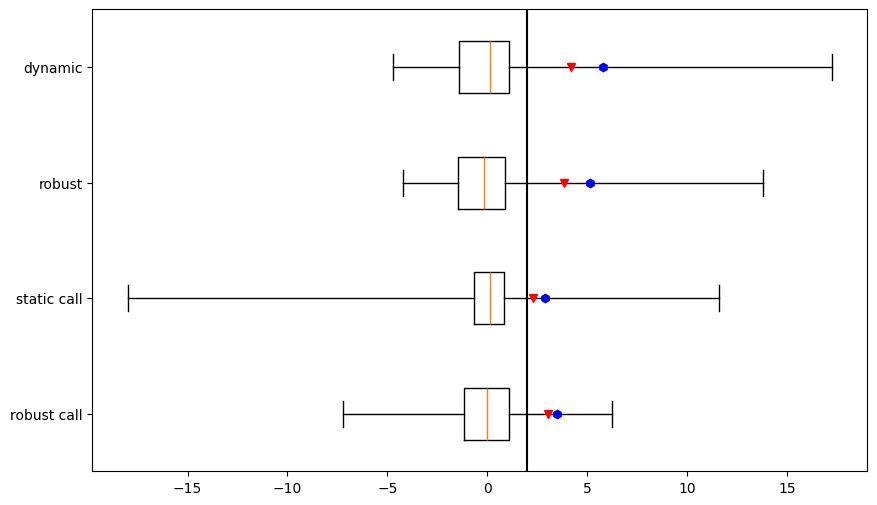

In [27]:
Losses =  [(Loss_robustcall),(Loss_staticcall),(Loss_robust),(Loss_dynamic)]
Labels = ["robust call","static call","robust","dynamic"]
fig = plt.figure(figsize=(10,6))
plt.boxplot(Losses,showfliers=False,vert=False, labels=Labels, whis= (0, 100))
plt.plot([VAR_robust_call, Var_staticcall,  VAR_robust, VAR_dynamic],[1, 2, 3, 4 ],'rv', ls='none')
plt.plot([ES_robust_call, ES_staticcall,  ES_robust, ES_dynamic],[1, 2, 3, 4 ],'bh', ls='none')
plt.axvline(bs_call_110, color='black')
# plt.rcParams.update({
#     "font.family": "serif",
#     # Use LaTeX default serif font.
#     "font.serif": [],
#     # Use specific cursive fonts.
#     "font.cursive": ["Comic Neue", "Comic Sans MS"],
# })
plt.show()


In [ ]:
sample=aic_heston.sample(n=10000,replace=True, weights="Prob", ignore_index=True)
Loss_dynamic=[]
Loss_staticput=[]
Loss_staticcall=[]
Loss_robust=[]

Steps = 250
sigma_pricing = 0.1351 #impl. vol for 1 year with strike 1.1 at 20.6.16
for index in range(len(sample)):
    S,v=heston_model_sim(S0=1., r=0., v0=sample["v_0"][index], rho=rho, kappa=kappa, theta=sample["theta"][index], sigma=sample["sigma_v"][index],T=1., N=Steps, M=1)
    bsdelta = []
    bsdelta1 = []
    bsdelta2 = []
    robustdelta = []
    dt = np.linspace(0., 1, Steps+1)
    
    for i in range(len(S)-1):
        bsdelta.append(bs_delta(S[i,0],K=1.1,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))
        bsdelta1.append(bs_delta(S[i,0],K=0.8,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Put")) # impl_vol = 0.2163
        bsdelta2.append(bs_delta(S[i,0],K=1,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Call")) ## impl_vol = 0.1586
    robustdelta=np.array(model([tf.reshape([S], [Steps+1,1]),tf.reshape([dt], [Steps+1,1])]))[:-1,0]
    
    hedge_dynamic=[bsdelta[0]]
    hedge_staticput=[bsdelta[0]-bsdelta1[0]]
    hedge_staticcall=[bsdelta[0]-bsdelta2[0]]
    hedge_robust=[robustdelta[0]]

    for i in range(len(bsdelta)-1):
        hedge_dynamic.append(bsdelta[i+1]-bsdelta[i])
        hedge_staticput.append(bsdelta[i+1]-bsdelta[i]-bsdelta1[i+1]+bsdelta1[i])
        hedge_staticcall.append(bsdelta[i+1]-bsdelta[i]-bsdelta2[i+1]+bsdelta2[i])
        hedge_robust.append(robustdelta[i+1]-robustdelta[i])
        
    hedge_dynamic.append(-np.sum(hedge_dynamic))
    hedge_staticput.append(-np.sum(hedge_staticput))
    hedge_staticcall.append(-np.sum(hedge_staticcall))
    hedge_robust.append(-np.sum(hedge_robust)) 

    Loss_dynamic.append(np.sum(S[:,0]*hedge_dynamic) + np.maximum((S[-1,0]-1.1),0)-0.0214) # Preis der Call Option mit Strike 1.1 ist 0.0214
    Loss_staticput.append(np.sum(S[:,0]*hedge_staticput) + np.maximum((S[-1,0]-1.1),0) - np.maximum((0.8-S[-1,0]),0) + 0.0151 -0.0214) # Preis der Put Option mit Strike 0.8 ist 0.0151
    Loss_staticcall.append(np.sum(S[:,0]*hedge_staticcall) + np.maximum((S[-1,0]-1.1),0) - np.maximum((S[-1,0]-1),0) + 0.0632 -0.0214) # Preis der Call Option mit Strike 1 ist 0.0632
    Loss_robust.append(np.sum(S[:,0]*hedge_robust) + np.maximum((S[-1,0]-1.1),0)-alpha)


In [97]:
VAR_dynamic = np.quantile(Loss_dynamic, 0.95)
Var_staticput = np.quantile(Loss_staticput, 0.95)
Var_staticcall = np.quantile(Loss_staticcall, 0.95)
VAR_robust = np.quantile(Loss_robust, 0.95)

ES_dynamic = np.quantile(np.array(Loss_dynamic)[Loss_dynamic>VAR_dynamic], 0.5)
ES_staticput = np.quantile(np.array(Loss_staticput)[Loss_staticput>Var_staticput], 0.5)
ES_staticcall = np.quantile(np.array(Loss_staticcall)[Loss_staticcall>Var_staticcall], 0.5)
ES_robust = np.quantile(np.array(Loss_robust)[Loss_robust>VAR_robust], 0.5)

print(VAR_dynamic)
print(Var_staticput)
print(Var_staticcall)
print(VAR_robust)
print("\n")

print(ES_dynamic)
print(ES_staticput)
print(ES_staticcall)
print(ES_robust)

0.049748878746380815
0.05153207622129162
0.02469132854758118
0.047440489323900964


0.07324734233126018
0.07319110572358135
0.03133853021575256
0.06906111392411629


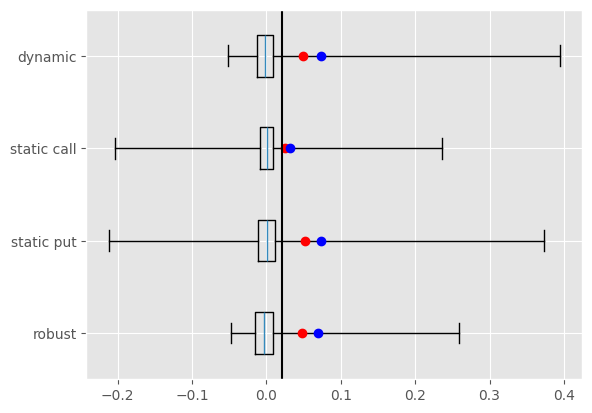

In [98]:
Losses =  [(Loss_robust), (Loss_staticput), (Loss_staticcall), (Loss_dynamic)]
Labels = ['robust','static put', 'static call', 'dynamic']
plt.boxplot(Losses,showfliers=False,vert=False, labels=Labels, whis= (0, 100))
plt.plot([VAR_dynamic, Var_staticput, Var_staticcall, VAR_robust],[4, 2, 3, 1],'ro', ls='none')
plt.plot([ES_dynamic, ES_staticput, ES_staticcall, ES_robust],[4, 2, 3, 1],'bo', ls='none')
plt.axvline(0.0214, color='black')
plt.show()
# Preis der Option : 0.021

In [ ]:
#Test auswertung mit daten generiert wie für neuronales netz

In [254]:
v0, kappa, theta, sigma, rho=(0.029547539464075276,
 0.4666888846590575,
 0.09999999999999999,
 0.4999266234077456,
 -0.8598476317638354)
v0_min,v0_max=(0.029037539464075297, 0.030057539464075255)
zeta_min, zeta_max = (0.09833000000000064, 0.10168999999999934)
nu_min, nu_max = (0.49102662340774655, 0.5089266234077446)

T = 1 # Maturity
n = 250 # Trading Dates
a_0 = [0,0] #fixer Parameter
a_1 = [nu_min**2, nu_max**2] 
b_0 = [kappa*zeta_min, kappa*zeta_max] # kappa * Intervall von Zeta
b_1 = [-kappa,-kappa] #fixer Parameter
gamma = [0.5,0.5] #fixer Parameter
v_0 = [v0_min,v0_max] # Eigentlich Variabel 0.013, 0.0145
s_0 = 100


In [253]:
def generate_path_heston(a_0, # Interval for Parameter a_0
              a_1, # Interval for  Parameter a_1
              b_0, # Interval for  Parameter b_0
              b_1, # Interval for  Parameter b_1
              gamma, # Interval for  Gamma
              v_0, # Initial value of Variation
              s_0, # Initial value of Assetprice
              rho, # Correlation of Brownian Motion
              T, # Maturity (in years)
              n, # Nr of trading days
              seed = 0): 

    #Time difference between trading days:
    dt = T/n
    # Create the differences of a Brownian Motion
    # Set the random seed for the Brownian motion - if desired
    if seed != 0:
        np.random.seed(seed)    
    dW1 = np.sqrt(dt) * np.random.randn(n)
    dW2 = np.sqrt(dt) * np.random.randn(n)
    # Dummy for Integral
    dV = rho*dW1+np.sqrt(1-rho**2)*dW2
    
    # Apply the Euler Maruyama Scheme
    # Use real randomness for the parameters!
    np.random.seed()
    # Initial value
    V = [v_0[0] + (v_0[1]-v_0[0])*np.random.uniform()]
    S_log = [np.log(s_0)]
    for i in range(n):
        # Choose random samples in each step
        a_0_sample = a_0[0] + (a_0[1]-a_0[0])*np.random.uniform() 
        a_1_sample = a_1[0] + (a_1[1]-a_1[0])*np.random.uniform()
        b_0_sample = b_0[0] + (b_0[1]-b_0[0])*np.random.uniform()
        b_1_sample = b_1[0] + (b_1[1]-b_1[0])*np.random.uniform()
        gamma_sample = gamma[0] + (gamma[1]-gamma[0])*np.random.uniform()
        #Compute the discretized value
        V += [np.maximum(V[-1]+(b_0_sample+b_1_sample*V[-1])*dt+((a_0_sample+a_1_sample*np.max([V[-1],0]))**gamma_sample)*dW1[i],0)]
        S_log += [S_log[-1] - dV[-1]*dt/2 + np.sqrt(V[-1])*dV[i]]
    return np.exp(S_log)


In [279]:
sample=aic_heston.sample(n=500000,replace=True, weights="prob", ignore_index=True)
Loss_dynamic=[]
Loss_staticput=[]
Loss_staticcall=[]
Loss_robust=[]
Steps = 250
sigma_pricing = 0.1351 #impl. vol for 1 year with strike 1.1 at 20.6.16

#bs_call_110=bs_call(100.,110.,1.,0.,0.1351)
bs_call_110= 2.0032079544841004

#0.2481 impl. vol for 1 year with strike 0.8 at 20.6.16
bs_put_80 = 2.2205584148988677
#0.1730 impl. vol for 1 year with strike 1.0 at 20.6.16
bs_call_100 = 6.893104392699136

for index in range(len(sample)):
    a_0 = [0,0] #fixer Parameter
    a_1 = [sample["sigma_v"][index]**2, sample["sigma_v"][index]**2] 
    b_0 = [kappa*sample["theta"][index], kappa*sample["theta"][index]] # kappa * Intervall von Zeta
    b_1 = [-kappa,-kappa] #fixer Parameter
    gamma = [0.5,0.5] #fixer Parameter
    v_0 = [sample["v_0"][index],sample["v_0"][index]] # Eigentlich Variabel 0.013, 0.0145
    s_0 = 100
    S= generate_path_heston(a_0, # Interval for Parameter a_0
              a_1, # Interval for  Parameter a_1
              b_0, # Interval for  Parameter b_0
              b_1, # Interval for  Parameter b_1
              gamma, # Interval for  Gamma
              v_0, # Initial value of Variation
              s_0, # Initial value of Assetprice
              rho, # Correlation of Brownian Motion
              T, # Maturity (in years)
              n, # Nr of trading days
              )
    bsdelta = []
    bsdelta1 = []
    bsdelta2 = []
    robustdelta = []
    dt = np.linspace(0., 1, Steps+1)

    bsdelta.append(-bs_delta(S[:-1],K=110,T=1-dt[:-1],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))
    bsdelta1.append(bs_delta(S[:-1],K=80,T=1-dt[:-1],r=0,q=0,sigma=sigma_pricing,CallPut="Put")) 
    bsdelta2.append(bs_delta(S[:-1],K=100,T=1-dt[:-1],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))   
    # for i in range(len(S)-1):
    #     bsdelta.append(-bs_delta(S[i,0],K=110,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))
    #     bsdelta1.append(bs_delta(S[i,0],K=80,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Put")) 
    #     bsdelta2.append(bs_delta(S[i,0],K=100,T=1-dt[i],r=0,q=0,sigma=sigma_pricing,CallPut="Call"))
    robustdelta=np.array(model([np.reshape([S], [Steps+1,1]),np.reshape([dt], [Steps+1,1])]))[:-1,0]

    bsdeltahedge_call = np.add(bsdelta,bsdelta2)
    bsdeltahedge_put = np.add(bsdelta,bsdelta1)
    
    patch_diff = S[1:]-S[:-1]
    bs_delta_S = np.sum(np.multiply(patch_diff[:],bsdelta))
    bs_delta1_S = np.sum(np.multiply(patch_diff[:],bsdeltahedge_put))
    bs_delta2_S = np.sum(np.multiply(patch_diff[:],bsdeltahedge_call))
    robust_delta_S = np.sum(np.multiply(patch_diff[:],robustdelta))

    payoff = -np.maximum((S[-1]-110),0) # short position
    payoff_call = np.maximum((S[-1]-100),0) # long position
    payoff_put = np.maximum((80-S[-1]),0) # long position
    
    Loss_dynamic.append(-bs_call_110+bs_delta_S-payoff)
    Loss_staticput.append(-bs_call_110+bs_delta1_S-payoff-payoff_put+bs_put_80)#anpassen
    Loss_staticcall.append(-bs_call_110+bs_delta2_S-payoff-payoff_call+bs_call_100)#anpassen
    Loss_robust.append(alpha + robust_delta_S - payoff) #minus oder plus delta?


In [280]:
VAR_dynamic = np.quantile(Loss_dynamic, 0.95)
Var_staticput = np.quantile(Loss_staticput, 0.95)
Var_staticcall = np.quantile(Loss_staticcall, 0.95)
VAR_robust = np.quantile(Loss_robust, 0.95)

ES_dynamic = np.quantile(np.array(Loss_dynamic)[Loss_dynamic>VAR_dynamic], 0.5)
ES_staticput = np.quantile(np.array(Loss_staticput)[Loss_staticput>Var_staticput], 0.5)
ES_staticcall = np.quantile(np.array(Loss_staticcall)[Loss_staticcall>Var_staticcall], 0.5)
ES_robust = np.quantile(np.array(Loss_robust)[Loss_robust>VAR_robust], 0.5)

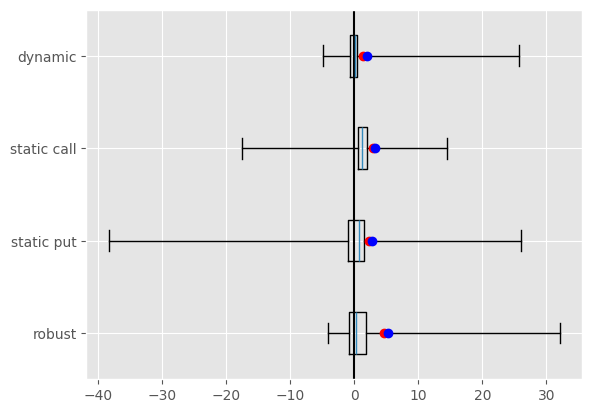

In [281]:
Losses =  [(Loss_robust), (Loss_staticput), (Loss_staticcall), (Loss_dynamic)]
Labels = ['robust','static put', 'static call', 'dynamic']
plt.boxplot(Losses,showfliers=False,vert=False, labels=Labels, whis= (0, 100))
plt.plot([VAR_dynamic, Var_staticput, Var_staticcall, VAR_robust],[4, 2, 3, 1],'ro', ls='none')
plt.plot([ES_dynamic, ES_staticput, ES_staticcall, ES_robust],[4, 2, 3, 1],'bo', ls='none')
plt.axvline(0.0214, color='black')
plt.show()

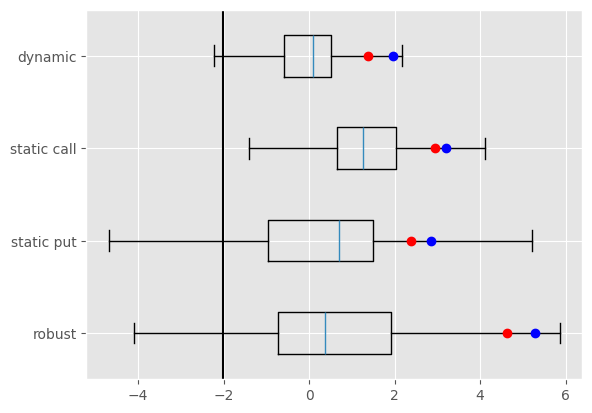

In [282]:
Losses =  [(Loss_robust), (Loss_staticput), (Loss_staticcall), (Loss_dynamic)]
Labels = ['robust','static put', 'static call', 'dynamic']
plt.boxplot(Losses,showfliers=False,vert=False, labels=Labels)#, whis= (0, 100))
plt.plot([VAR_dynamic, Var_staticput, Var_staticcall, VAR_robust],[4, 2, 3, 1],'ro', ls='none')
plt.plot([ES_dynamic, ES_staticput, ES_staticcall, ES_robust],[4, 2, 3, 1],'bo', ls='none')
plt.axvline(-bs_call_110, color='black')
plt.show()